In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM

In [112]:
def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_logits: [batch, H, W, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H, W, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H, W, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the featuremap
    #       is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)
    

    
    #print("x: ",x)
    #print(K.int_shape(x))
    #print(tf.shape(input=x)[0])
    #print("nur reshape:", tf.reshape(x, [tf.shape(input=x)[0], -1, 2]))
    #func = lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 2])
    #print("nur lambda func:", func(x))



    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 2]))(x)
    print("lambda func + lambda layer:", func(x))

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location, depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]

Creating Inputs for the rpn_model and the rpn_graph

In [113]:
input_feature_map = KL.Input(shape=[ 7, 7, 256],name="input_rpn_feature_map")
anchors_per_location = 3
anchor_stride = 1

In [114]:
outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)

rpn_model = KM.Model([input_feature_map], outputs, name="rpn_model")

tf.Tensor(
[[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]], shape=(3, 2, 4, 5), dtype=float32)
x:  tf.Tensor(
[[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 

In [79]:
rpn_model.summary()

Model: "rpn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rpn_feature_map (InputLay [(None, 7, 7, 256)]  0                                            
__________________________________________________________________________________________________
rpn_conv_shared (Conv2D)        (None, 7, 7, 512)    1180160     input_rpn_feature_map[0][0]      
__________________________________________________________________________________________________
rpn_class_raw (Conv2D)          (None, 7, 7, 6)      3078        rpn_conv_shared[0][0]            
__________________________________________________________________________________________________
lambda_36 (Lambda)              (None, None, 2)      0           rpn_class_raw[0][0]              
__________________________________________________________________________________________

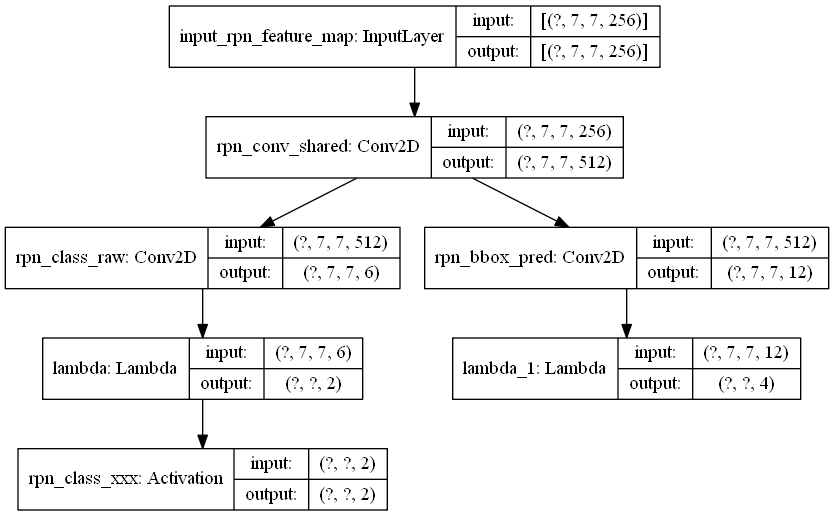

In [6]:
#keras.utils.plot_model(rpn_model, "rpn_model.png", show_shapes=True)

In [ ]:
print(tf.shape(input=[2,10]))
print(tf.shape(input=[2,10,5,8,16]))
print(tf.shape(input=[(2,10)]))
print(tf.shape(input=[(2,15,10)]))